In [16]:
# install library requirements
!pip install pymaxflow

# import libraries
import pandas as pd
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

import maxflow as mf
import time
from random import shuffle
from PIL import Image


In [23]:
def load_img(img_path):
    img_path = "17/" + img_path
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = np.array(img)
    return img

# apply global thresholding
def hist_thresh(img,T,delta):
    image=img.copy()
    new_img=np.zeros(image.shape)
    temp=image.astype(int)
    while(True):
        m1=temp[np.where(temp>T)].mean()
        m2=temp[np.where(temp<=T)].mean()
        T_new=0.5*(m1+m2)
    # print(T_new)
        if abs(T-T_new)<delta:
            break
        T=T_new
  
    new_img=(temp-T < 0).astype(int)
    #new_img=(temp-T > 0).astype(int)
    #uncomment above line if the region of interest consists of brighter pixels
    new_img = np.uint8(new_img)*255
    return new_img

In [24]:

def image_to_array(img):
    img = Image.fromarray(img)    
    w, h = img.size
    data = list(img.getdata())
    data = [data[off:off+w] for off in range(0, w*h, w)]
    
    return data

def calculate_energy(img_orig, img_work):
    E_data = 0
    for i in range(len(img_orig)):
        for j in range(len(img_orig[0])):
            E_data += D_p(img_orig[i][j], img_work, j, i)
    
    E_smooth = 0
    for i in range(len(img_orig)):
        for j in range(len(img_orig[0])):
            ns = give_neighbours(img_work, j, i)
            E_smooth += sum([V_p_q(v, img_work[i][j]) for v in ns])

    return E_data + E_smooth

     
def V_p_q(label1, label2):
    return 23*abs(label1-label2)
    
    
def D_p(label, graph, x, y):
    return ((abs(label**2-graph[y][x]**2))**0.5)/  

def give_neighbours(image, x, y):
    if x>=len(image[0]) or x<0 or y>=len(image) or y<0:
        raise ValueError('Pixel is not in image. x and/or y are to large')
    ns = []
    for a,b in zip([1,0,-1,0],[0,1,0,-1]):
        if (x+a<len(image[0]) and x+a>=0) and (y+b<len(image) and y+b>=0):
            ns.append(image[y+b][x+a])
    return ns 

def return_mapping_of_image(image, alpha, beta, method = "ab"):
    map = {}
    revmap = {}
    map_parameter = 0
    for y in range(len(image)):
        for x in range(len(image[0])):
            if image[y][x] == alpha or image[y][x] == beta:
                map[map_parameter] = (y,x)
                revmap[(y,x)] = map_parameter
                map_parameter += 1
    
    cutoff = len(map)

    if method == "ae":
        for y in range(len(image)):
            for x in range(len(image[0])):
                for a,b in zip([1,0,-1,0],[0,1,0,-1]):
                    if (x+a<len(image[0]) and x+a>=0) and (y+b<len(image) and y+b>=0):
                        if image[y][x] != image[y + b][x + a]:
                            x_new = (x + x + a) / 2
                            y_new = (y + y + b) / 2

                            if (x_new, y_new) not in revmap:
                                map[map_parameter] = (y_new,x_new)
                                revmap[(y_new,x_new)] = map_parameter
                                map_parameter += 1

    return map, revmap, cutoff


def alpha_beta_swap_new(alpha, beta, img_orig, img_work):
    
    map, revmap, cutoff = return_mapping_of_image(img_work, alpha, beta, method = "ab")

 
    graph_mf = mf.Graph[float](len(map) )
    nodes = graph_mf.add_nodes(len(map))


    weight = V_p_q(alpha, beta)
    for i in range(0,len(map)):
        y,x = map[i]
        for a,b in zip([1,0,-1,0],[0,1,0,-1]):
            if (y+b, x+a) in revmap:
                graph_mf.add_edge(i,revmap[(y+b,x+a)], weight, 0)
   

    for i in range(0,len(map)):
        y,x = map[i]
        neighbours = give_neighbours(img_work, x, y)
        fil_neigh = list(filter(lambda i: i!=alpha and i!=beta, neighbours))
        t_weight_alpha = sum([V_p_q(alpha,v) for v in fil_neigh]) + D_p(alpha, img_orig, x, y)
        t_weight_beta = sum([V_p_q(beta,v) for v in fil_neigh]) + D_p(beta, img_orig, x, y)
        graph_mf.add_tedge(nodes[i], t_weight_alpha, t_weight_beta)

    flow = graph_mf.maxflow()
    res = [graph_mf.get_segment(nodes[i]) for i in range(0, cutoff)]
    
    for i in range(0, len(res)):
        y, x = map[i] 
        if res[i] == 1:
            img_work[y][x] = alpha 
        else:
            img_work[y][x] = beta
    
    return img_work

def alpha_expansion(alpha, beta, img_orig, img_work):

    map, revmap, cutoff = return_mapping_of_image(img_work, alpha, beta, method = "ae")
      
    graph_mf = mf.Graph[float](len(map) )
    nodes = graph_mf.add_nodes(len(map))

    for i in range(0, cutoff):
        y,x = map[i]
        for a,b in zip([1,0,-1,0],[0,1,0,-1]):
            if (x+a<len(img_work[0]) and x+a>=0) and (y+b<len(img_work) and y+b>=0):
                if (y+(b/2), x+(a/2)) not in revmap:
                    weight = V_p_q(img_work[y][x], alpha)
                    graph_mf.add_edge(i,revmap[(y+b,x+a)], weight, 0)
                else:
                    weight_p = V_p_q(img_work[y][x], alpha)
                    graph_mf.add_edge(i,revmap[(y+(b/2), x+(a/2))], weight_p, 0)

                    weight_q = V_p_q(alpha, img_work[y+b][x+a])
                    graph_mf.add_edge(revmap[(y+(b/2), x+(a/2))], revmap[(y+b,x+a)], weight_q, 0)

                    t_weight_alpha = 0
                    t_weight_beta = V_p_q(img_work[y][x], img_work[y+b][x+a])
                    graph_mf.add_tedge(nodes[revmap[(y+(b/2), x+(a/2))]], t_weight_alpha, t_weight_beta)

    for i in range(0,cutoff):

        if (i < cutoff):
            y,x = map[i]
            t_weight_alpha = D_p(alpha, img_orig, x, y)
            if (img_work[y][x] == alpha): 
                t_weight_beta = np.inf
            else:
                t_weight_beta = D_p(img_work[y][x], img_orig, x, y)
            graph_mf.add_tedge(nodes[i], t_weight_alpha, t_weight_beta)

    flow = graph_mf.maxflow()
    res = [graph_mf.get_segment(nodes[i]) for i in range(0, cutoff)]

    for i in range(0, len(res)):
        y, x = map[i] 
        if res[i] == 1:
            img_work[y][x] = alpha 
        else:
            img_work[y][x] = img_work[y][x]
      
    return img_work

def swap_minimization(img_orig, img_work, cycles, method):

    labels = []
    for i in range(0, len(img_orig)):
        for j in range(0, len(img_orig[0])):
            if img_orig[i][j] not in labels:
                labels.append(img_orig[i][j])
    labels = np.array(labels) 

    for u in range(0,cycles):

        if method == "ab":
          #iterate over all pairs of labels 
          for i in range(0, len(labels)-1):
                for j in range(i+1, len(labels)):
                    img_work  = alpha_beta_swap_new(labels[i],labels[j], img_orig, img_work)     
        
        if method == "ae":
            img_work  = alpha_expansion(labels[0],labels[1], img_orig, img_work)
            img_work  = alpha_expansion(labels[1],labels[0], img_orig, img_work)      
    
    return img_work

In [25]:
class evaluate:

    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred

    def jaccard(self):
        return sum(self.y_true*y_pred) / sum((self.y_true + y_pred > 0).astype(int))

    def dice(self):
        return 2 * sum(self.y_true*y_pred) / (sum(self.y_true) + sum(y_pred))

    def accuracy(self):
        return sum(self.y_true == y_pred) / len(self.y_true)

    def sensitivity(self):
        return sum(self.y_true*y_pred) / (sum(self.y_true))

    def specificity(self):
        return sum(abs(self.y_true - 1)*abs(y_pred - 1)) / sum(abs(self.y_true - 1))
  
    def summarize(self):
        print("Jaccard Coefficient Score : ", self.jaccard())
        print("Dice Coefficient Score : ", self.dice())
        print("Accuracy Score : ", self.accuracy())
        print("Sensitivity Score : ", self.sensitivity())
        print("Specificity Score : ", self.specificity())

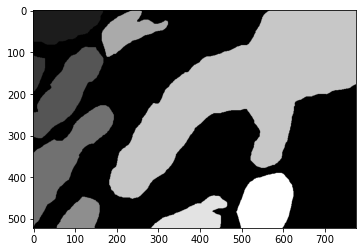

In [26]:
img_name = "train_5"
img_anno_path = img_name + "_anno.bmp"
img_anno = load_img(img_anno_path)
plt.imshow(img_anno, cmap = 'gray')

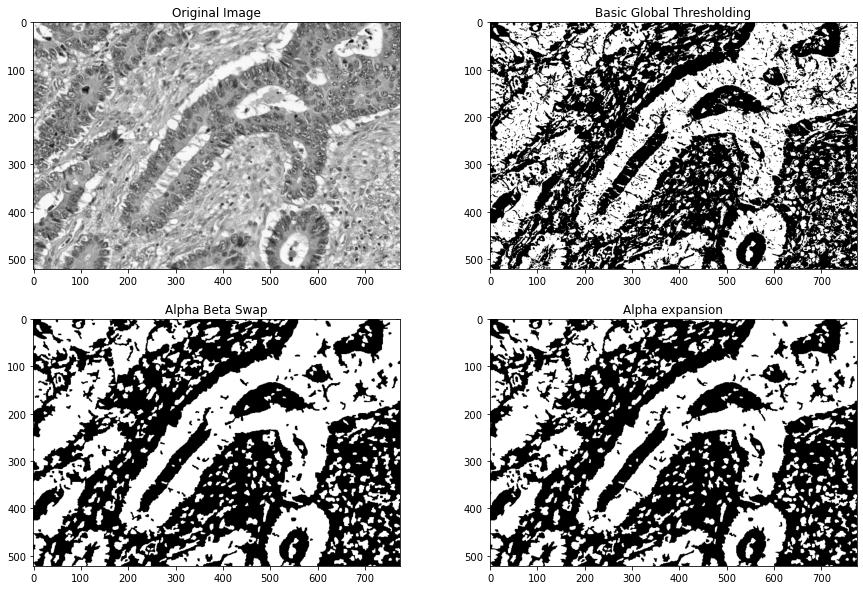

In [27]:
img_path = img_name + ".bmp"
img = load_img(img_path) # loading original image

img_new = hist_thresh(img,T = 127,delta = 1) # finding tresholded image

img_orig = image_to_array(img_new)
img_work = image_to_array(img_new)

ab_minimized = swap_minimization(img_orig, img_work, cycles = 5, method = "ab")

img_orig = image_to_array(img_new)
img_work = image_to_array(img_new)

ae_minimized = swap_minimization(img_orig, img_work, cycles = 5, method = "ae")

fig, axis = plt.subplots(2,2,figsize=(15,10))
axis[0][0].imshow(img, cmap = 'gray') # original image plot
axis[0][1].imshow(img_new, cmap = 'gray') # thresholded image plot
axis[1][0].imshow(ab_minimized, cmap = 'gray') # alpha beta swapped 
axis[1][1].imshow(ae_minimized, cmap = 'gray') # alpha expansion
axis[0][0].title.set_text('Original Image')
axis[0][1].title.set_text('Basic Global Thresholding')
axis[1][0].title.set_text('Alpha Beta Swap')
axis[1][1].title.set_text('Alpha expansion')

In [28]:
y_true = (img_anno.ravel() > 0).astype(int)
y_pred = (np.array(ab_minimized).ravel() == 255).astype(int)
                                                        
img_score = evaluate(y_true, y_pred)
print("Alpha Beta Swapping Performance")
img_score.summarize()

y_pred = (np.array(ae_minimized).ravel() == 255).astype(int)
                                                        
img_score = evaluate(y_true, y_pred)
print("\nAlpha Expansion Performance")
img_score.summarize()

y_pred = (np.array(img_new).ravel() == 255).astype(int)
                                                        
img_score = evaluate(y_true, y_pred)
print("\nGlobal Histogram Thresholding Performance")
img_score.summarize()

Alpha Beta Swapping Performance
Jaccard Coefficient Score :  0.6127503391047634
Dice Coefficient Score :  0.7598824495611648
Accuracy Score :  0.7600593251761216
Sensitivity Score :  0.7635315172002386
Specificity Score :  0.756625202812331

Alpha Expansion Performance
Jaccard Coefficient Score :  0.6075051934876081
Dice Coefficient Score :  0.7558360569518013
Accuracy Score :  0.7590137189469781
Sensitivity Score :  0.7501342215152118
Specificity Score :  0.7677958601701165

Global Histogram Thresholding Performance
Jaccard Coefficient Score :  0.5486343588410767
Dice Coefficient Score :  0.7085395667595135
Accuracy Score :  0.7123767148683723
Sensitivity Score :  0.7030870948498708
Specificity Score :  0.7215644820295983
